# 大作业——方差缩减类算法实现与比较

------------------

## 1 理论分析

#### 实现了4个算法，分别是SAG 算法、SAGA 算法、SVRG 算法、SARAH 算法。算法分析以及伪代码等详见综述论文

---

## 2 问题建模：
### 将二分类问题建模成L2正则逻辑回归[L2-regularized Logistic Regression]

#### 2.1 目标loss函数
$$\underset{w \in \mathbb{R}^{p}}{\operatorname{minimize}} \quad g(w):=\frac{1}{n} \sum_{i=1}^{n} f_{i}(w)$$  
$$f_{i}(w):=\frac{\lambda}{2}\|w\|^{2}+\log (1+\left.\exp \left(-y_{i} x_{i}^{T} w\right)\right)$$  
其中$x_{i} \in \mathbb{R}^{p} \text { and } y_{i} \in\{-1,1\}$是总共n个样本的特征以及标签，优化的变量是权重$w$。  
#### 2.2 每个样本损失函数的导函数：

$$\nabla f_{i}(w) = \lambda w - \frac{y_i \exp \left(-y_{i} x_{i}^{T} w\right)}{1+ \exp \left(-y_{i} x_{i}^{T} w\right)}x_i$$

----------

## 3 实验部分
### 3.1.1 选用数据集：w8a以及ijcnn1[都是二分类数据集]
数据库网址：https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

数据集信息（两个文档数据集，样本数目都不算大，特征维度w8a比ijcnn1略微高一点，但是也没有很高，不像之前某次作业用过的rcv1和covtype“一个特征维度很高，一个样本数目很大”这样各具特色）：  
w8a：&nbsp;&nbsp;&nbsp;&nbsp; # of data: 49,749 / 14,951 (testing) ；&nbsp; # of features: 300 &nbsp;&nbsp;&nbsp;&nbsp;  
ijcnn1：# of data:  49,990 / 91,701 (testing) ；# of features: 22 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
（下载后解压得w8a、w8a.t以及ijcnn1、ijcnn1.t四个文件放置于本notebook代码同一目录下）

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
import warnings
warnings.filterwarnings("ignore")

### 3.1.2 训练/测试数据集读入、清洗

In [2]:
def read_dataset_file(filename):
    from sklearn.datasets import load_svmlight_file  #注意，这里只调用了dataset中读入数据的函数，除此之外不会调用任何其他第三方函数。
    X, y = load_svmlight_file(filename)
    df_x = pd.DataFrame(X.todense())
    df_y = pd.DataFrame(y)
    df_y.columns = ['label']
    df = pd.concat([df_y, df_x], axis=1)
    return df

def prepare_dataframe(train_filename, test_filename):
    ########### 数据读入 ###########
    train_df = read_dataset_file(train_filename)
    test_df = read_dataset_file(test_filename)
    ########### 数据清洗 ###########
    train_df.dropna(inplace=True)
    test_df.dropna(inplace=True)
    ########## 数据集统计 ##########
    print("训练数据集shape和测试数据集shape:")
    print(train_df.shape, test_df.shape)
    ###### 给训练集附加上index ##### 
    train_df = train_df.reset_index()
    train_df['index'] = pd.DataFrame(range(train_df.shape[0])).astype(int)
    return train_df, test_df

**读入w8a数据集**

In [3]:
#读入w8a数据集
train_df_w8a, test_df_w8a = prepare_dataframe("w8a","w8a.t")
train_df_w8a.head(5)

训练数据集shape和测试数据集shape:
(49749, 301) (14951, 301)


,index,label,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**读入ijcnn1数据集**

In [4]:
#读入ijcnn1数据集
train_df_ijcnn1, test_df_ijcnn1 = prepare_dataframe("ijcnn1", "ijcnn1.t")
train_df_ijcnn1.head(5)

训练数据集shape和测试数据集shape:
(49990, 23) (91701, 23)


,index,label,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
0,0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000270,0.011684,-0.011052,0.024452,0.008337,0.001324,0.025544,-0.040728,-0.000810
1,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000270,0.011684,-0.011052,0.024452,0.008337,0.001324,0.025544,-0.040728,-0.000810,-0.003890
2,2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.011684,-0.011052,0.024452,0.008337,0.001324,0.025544,-0.040728,-0.000810,-0.003890,0.004604
3,3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011052,0.024452,0.008337,0.001324,0.025544,-0.040728,-0.000810,-0.003890,0.004604,0.003551
4,4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024452,0.008337,0.001324,0.025544,-0.040728,-0.000810,-0.003890,0.004604,0.003551,-0.024589


### 3.2.0 共享的公共函数实现
为实现更加模块化、更加简洁明了的代码，定义以下算法都会用到的共享函数，比如计算损失函数、计算梯度、测试并返回验证结果等等

In [5]:
def loss_func_i(xi,yi,w,lamda):
    if np.exp(-yi * np.dot(xi,w)) != float("inf"):
        return 0.5*lamda*np.dot(w,w) + np.log(1 + np.exp(-yi * np.dot(xi,w)))
    else:
        return 0.5*lamda*np.dot(w,w) + -yi * np.dot(xi,w) #处理溢出的情况
    
def cal_grad_i(xi,yi,w,lamda):
    return lamda * w - 1 / (1 / np.exp(-yi * np.dot(xi,w)) + 1) * yi * xi

def test(test_df,w,lamda):
    loss_epoch = 0
    for data in test_df.values:
        xi = data[1:]
        yi = data[0]
        loss_epoch += loss_func_i(xi,yi,w,lamda)
        probability = 1 / (1 + np.exp(-np.dot(xi,w)))
        if probability > 0.5:
            pred = 1
        else:
            pred = -1
    return loss_epoch/test_df.shape[0]

### 3.2.1 SAG算法实现
实现细节：下面实验中会使用论文中的设置$\lambda$=1/n，其他部分按照综述中的伪代码实现即可。

In [6]:
def SAG(train_df,test_df,num_epoch,lamda,learning_rate):
    d = 0
    w = np.ones(train_df.shape[1]-2) # initialize w
    history = np.zeros([train_df.shape[0],train_df.shape[1]-2])
    np.random.seed(0)
    train_loss = []
    test_loss = []
    d_norm = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle
            d_norm_epoch = 0
            for data in train_df.values:
                i = int(data[0]) # index
                xi = data[2:]
                yi = data[1]
                gredient = cal_grad_i(xi,yi,w,lamda)
                d = d - history[i] + gredient
                d_norm_epoch += np.linalg.norm(d)
                history[i] = gredient
                w = w - learning_rate / train_df.shape[0] * d
            d_norm_epoch /= train_df.shape[0]
            ########## TEST ##########
            test_loss_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            d_norm.append(d_norm_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, direction_norm_epoch=d_norm_epoch)
    return train_loss, test_loss, d_norm

### 3.2.2 SAGA算法实现
实现细节：下面实验中采用设置$\lambda$=1/n，其他部分按照综述中的伪代码实现即可。

In [7]:
def SAGA(train_df,test_df,num_epoch,lamda,learning_rate):
    d = 0
    w = np.ones(train_df.shape[1]-2) # initialize w
    history = np.zeros([train_df.shape[0],train_df.shape[1]-2])
    history_avg = np.mean(history)
    np.random.seed(0)
    train_loss = []
    test_loss = []
    d_norm = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle
            d_norm_epoch = 0
            for data in train_df.values:
                i = int(data[0]) # index
                xi = data[2:]
                yi = data[1]
                gredient = cal_grad_i(xi,yi,w,lamda)
                d = gredient - history[i] + history_avg
                d_norm_epoch += np.linalg.norm(d)
                history_avg = history_avg + (gredient - history[i])/train_df.shape[0]
                history[i] = gredient
                w = w - learning_rate * d
            d_norm_epoch /= train_df.shape[0]
            ########## TEST ##########
            test_loss_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            d_norm.append(d_norm_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, direction_norm_epoch=d_norm_epoch)
    return train_loss, test_loss, d_norm

### 3.2.3 SVRG算法实现
实现细节：下面实验中会使用论文中的设置$\lambda$=1e-5，内循环m=n（论文原文是2n或者5n），更新策略是option I，其他部分按照综述中的伪代码实现即可。

In [8]:
def SVRG(train_df,test_df,num_epoch,lamda,learning_rate):
    w = np.ones(train_df.shape[1]-2) # initialize w
    np.random.seed(0)
    train_loss = []
    test_loss = []
    d_norm = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            grad_global = 0
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
                grad_global += cal_grad_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            grad_global /= train_df.shape[0]
            w_tem = w
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle；m=n
            d_norm_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                d = cal_grad_i(xi,yi,w_tem,lamda) - cal_grad_i(xi,yi,w,lamda) + grad_global
                d_norm_epoch += np.linalg.norm(d)
                w_tem = w_tem - learning_rate * d
            d_norm_epoch /= train_df.shape[0]
            w = w_tem # option I
            ########## TEST ##########
            test_loss_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            d_norm.append(d_norm_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, direction_norm_epoch=d_norm_epoch)
    return train_loss, test_loss, d_norm

### 3.2.4 SARAH算法实现
实现细节：下面实验中会使用论文中的设置$\lambda$=1/n，内循环m=n，更新策略是option I，其他部分按照综述中的伪代码实现即可。

In [9]:
def SARAH(train_df,test_df,num_epoch,lamda,learning_rate):
    w = np.ones(train_df.shape[1]-2) # initialize w
    np.random.seed(0)
    train_loss = []
    test_loss = []
    d_norm = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            grad_global_i = 0
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
                grad_global_i += cal_grad_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            grad_global_i /= train_df.shape[0]
            w_last = w
            w_now = w - learning_rate * grad_global_i
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle；m=n
            d_norm_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                grad_global_i = cal_grad_i(xi,yi,w_now,lamda) - cal_grad_i(xi,yi,w_last,lamda) + grad_global_i
                d_norm_epoch += np.linalg.norm(grad_global_i)
                w_last = w_now
                w_now = w_now - learning_rate * grad_global_i
            d_norm_epoch /= train_df.shape[0]
            w = w_now # option I
            ########## TEST ##########
            test_loss_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            d_norm.append(d_norm_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, direction_norm_epoch=d_norm_epoch)
    return train_loss, test_loss, d_norm

#### 3.2.3 其他辅助函数（画图）

In [10]:
def plot_statistic_curves(num_epochs,train_loss,test_loss,d_norm,name):
    fig = plt.figure(figsize=(22,6))
    plt.subplot(1,3,1)
    plt.title('train_loss over epochs')
    plt.plot(range(num_epochs),train_loss,c='r')
    plt.xlabel('# of epoches')
    plt.ylabel('train_loss')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()
    plt.subplot(1,3,2)
    plt.title('test_loss over epochs')
    plt.plot(range(num_epochs),test_loss,c='g')
    plt.xlabel('# of epoches')
    plt.ylabel('test_loss')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()
    plt.subplot(1,3,3)
    plt.title('direction_norm over epochs')
    plt.plot(range(num_epochs),d_norm,c='b')
    plt.xlabel('# of epoches')
    plt.ylabel('direction_norm')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()
    fig.savefig(name,dpi=600,format='png',bbox_inches='tight')    

### 3.3 实验结果
### 3.3.1 w8a数据集结果

**以下依次执行SAG、SAGA、SVRG、SARAH算法得到各自的结果，最后会绘制一个总图进行比较**  
*注意：结果都是没有进行刻意的调参得到的（由于能调的参数还是挺多的，因此我并没有很多的时间刻意地去把参数全部都调的非常精确），不过由于算法实现的比较完整没有bug，而且这些论文中一些基础的结论都还是得到了验证*

#### SAG算法

Epoch Loop: 100%|██████████| 30/30 [01:24<00:00,  2.82s/it, direction_norm_epoch=112, test_loss_epoch=0.146, train_loss_epoch=0.147] 


SAG算法——w8a数据集结果:


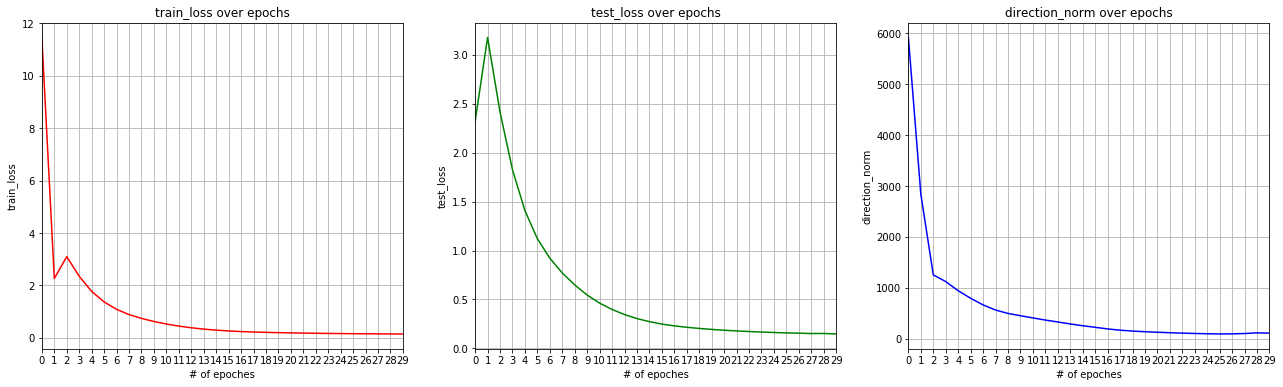

In [11]:
num_epochs = 30
lamda = 1 / (train_df_w8a.shape[0] + test_df_w8a.shape[0])
train_loss_sag, test_loss, d_norm_sag = SAG(train_df_w8a,test_df_w8a,num_epochs,lamda,learning_rate=0.025)
print("SAG算法——w8a数据集结果:")
plot_statistic_curves(num_epochs,train_loss_sag,test_loss,d_norm_sag,name='w8a_SAG.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAG算法的有效性以及鲁棒性  

#### SAGA算法

Epoch Loop: 100%|██████████| 30/30 [01:33<00:00,  3.12s/it, direction_norm_epoch=0.000681, test_loss_epoch=0.129, train_loss_epoch=0.126]


SAGA算法——w8a数据集结果:


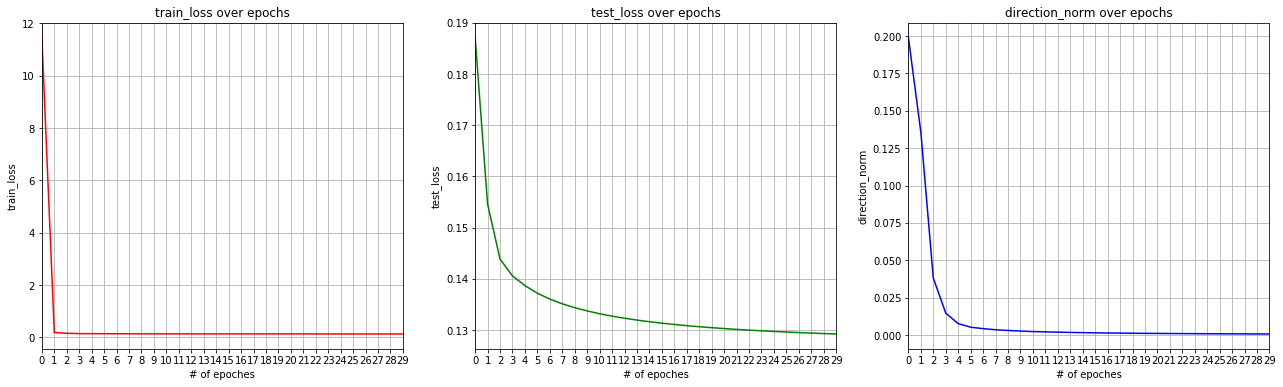

In [12]:
num_epochs = 30
lamda = 1 / (train_df_w8a.shape[0] + test_df_w8a.shape[0])
train_loss_saga, test_loss, d_norm_saga = SAGA(train_df_w8a,test_df_w8a,num_epochs,lamda,learning_rate=0.01)
print("SAGA算法——w8a数据集结果:")
plot_statistic_curves(num_epochs,train_loss_saga,test_loss,d_norm_saga,name='w8a_SAGA.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAGA算法的有效性以及鲁棒性 

#### SVRG算法

Epoch Loop: 100%|██████████| 30/30 [01:52<00:00,  3.74s/it, direction_norm_epoch=0.000757, test_loss_epoch=0.129, train_loss_epoch=0.126]


SVRG算法——w8a数据集结果:


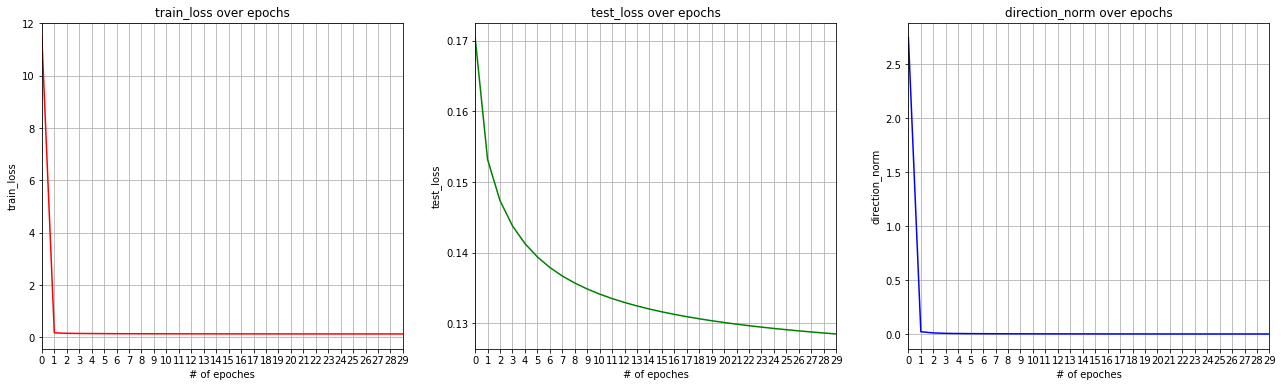

In [13]:
num_epochs = 30
lamda = 1e-5
train_loss_svrg, test_loss, d_norm_svrg = SVRG(train_df_w8a,test_df_w8a,num_epochs,lamda,learning_rate=0.0075)
print("SVRG算法——w8a数据集结果:")
plot_statistic_curves(num_epochs,train_loss_svrg,test_loss,d_norm_svrg,name='w8a_SVRG.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SVRG算法的有效性以及鲁棒性 

#### SARAH算法

Epoch Loop: 100%|██████████| 30/30 [01:52<00:00,  3.76s/it, direction_norm_epoch=0.000833, test_loss_epoch=0.131, train_loss_epoch=0.129]


SARAH算法——w8a数据集结果:


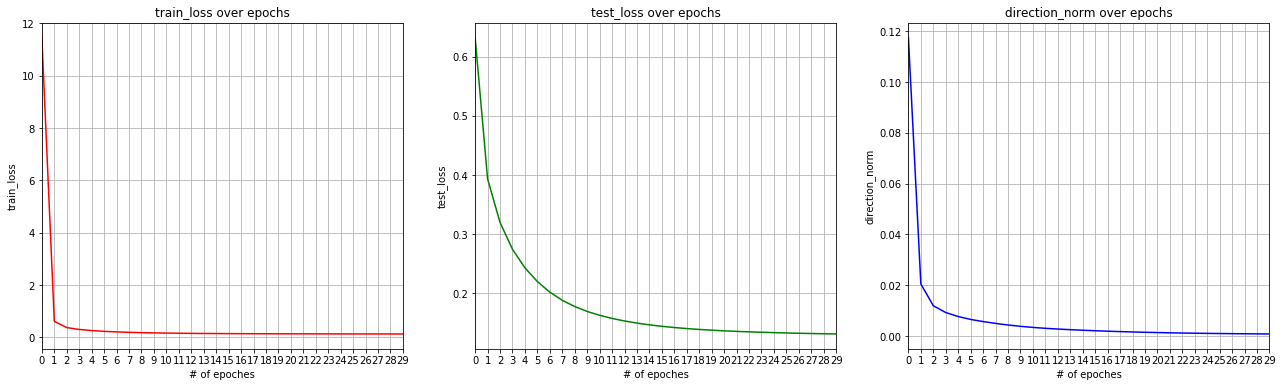

In [14]:
num_epochs = 30
lamda = 1 / (train_df_w8a.shape[0] + test_df_w8a.shape[0])
train_loss_sarah, test_loss, d_norm_sarah = SARAH(train_df_w8a,test_df_w8a,num_epochs,lamda,learning_rate=0.01)
print("SARAH算法——w8a数据集结果:")
plot_statistic_curves(num_epochs,train_loss_sarah,test_loss,d_norm_sarah,name='w8a_SARAH.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SARAH算法的有效性以及鲁棒性

#### w8a数据集上四类算法对比
**以下会按照要求，将四类算法的目标函数值与最优目标函数值之差变化曲线与迭代方向模长变化曲线放在一张图中对比！**  
*注：由于要求画出目标函数值与最优目标函数值之差变化曲线，其中最优目标值其实是没法精确的求解出来的（如果能精确求解出来也没必要研究这些算法了，退一步讲就算能求解那也需要花费超大的时间复杂度与计算资源），一般方法呢是用其它算法先运行一下，得到符合某精度的函数值，我们这里也是采用原论文中提到的，梯度下降跑很长的时间足够收敛可以看做为近似的optimum*

Epoch Loop: 100%|██████████| 100/100 [05:15<00:00,  3.15s/it, train_loss_epoch=0.121]


得到w8a数据集optimum！！
然后画出w8a在4个dataset上的对比图如下：


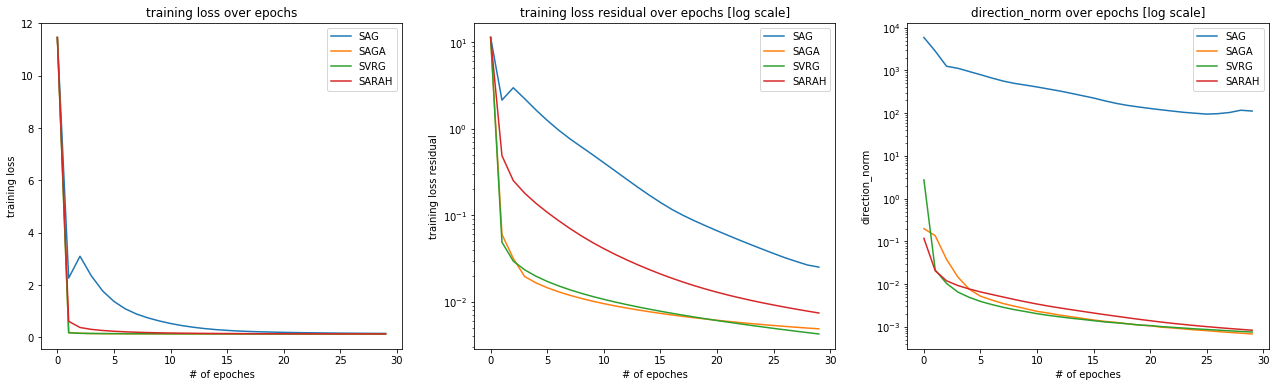

In [15]:
def optimum_w8a(train_df,num_epoch,lamda,learning_rate):
    w = np.ones(train_df.shape[1]-2) # initialize w
    np.random.seed(0)
    train_loss = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            grad_global = 0
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
                grad_global += cal_grad_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            grad_global /= train_df.shape[0]
            w_tem = w
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle；m=n
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                d = cal_grad_i(xi,yi,w_tem,lamda) - cal_grad_i(xi,yi,w,lamda) + grad_global
                w_tem = w_tem - learning_rate * d
            w = w_tem # option I
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch)
    return np.min(train_loss)
optimum_w8a = optimum_w8a(train_df_w8a,100,1e-5,learning_rate=0.25)
print("得到w8a数据集optimum！！\n然后画出w8a在4个dataset上的对比图如下：")
########## 画图 ##########
fig = plt.figure(figsize=(22,6))
x_data = range(30)
plt.subplot(1,3,1)
plt.title('training loss over epochs')
plt.plot(x_data, train_loss_sag, label='SAG')
plt.plot(x_data, train_loss_saga, label='SAGA')
plt.plot(x_data, train_loss_svrg, label='SVRG')
plt.plot(x_data, train_loss_sarah, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('training loss')
plt.legend()
plt.subplot(1,3,2)
plt.title('training loss residual over epochs [log scale]')
plt.plot(x_data, train_loss_sag - optimum_w8a, label='SAG')
plt.plot(x_data, train_loss_saga - optimum_w8a, label='SAGA')
plt.plot(x_data, train_loss_svrg - optimum_w8a, label='SVRG')
plt.plot(x_data, train_loss_sarah - optimum_w8a, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('training loss residual')
plt.yscale("log")
plt.legend()
plt.subplot(1,3,3)
plt.title('direction_norm over epochs [log scale]')
plt.plot(x_data, d_norm_sag, label='SAG')
plt.plot(x_data, d_norm_saga, label='SAGA')
plt.plot(x_data, d_norm_svrg, label='SVRG')
plt.plot(x_data, d_norm_sarah, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('direction_norm')
plt.yscale("log")
plt.legend()
fig.savefig('w8a_4comparison.png',dpi=600,format='png',bbox_inches='tight')

**结果分析见本notebook最后或者综述论文**

---

### 3.3.2 ijcnn1数据集结果

**以下依次执行SAG、SAGA、SVRG、SARAH算法得到各自的结果，最后会绘制一个总图进行比较**  
*注意：结果都是没有进行刻意的调参得到的（由于能调的参数还是挺多的，因此我并没有很多的时间刻意地去把参数全部都调的非常精确），不过由于算法实现的比较完整没有bug，因而对比图中能大致反应出相关结论*

#### SAG算法

Epoch Loop: 100%|██████████| 30/30 [01:30<00:00,  3.02s/it, direction_norm_epoch=16.8, test_loss_epoch=0.213, train_loss_epoch=0.185]  


SAG算法——ijcnn1数据集结果:


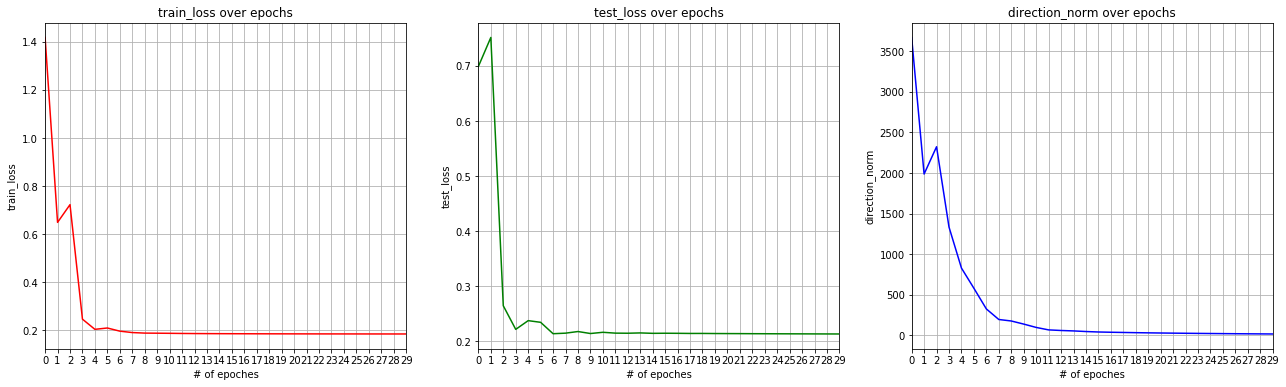

In [16]:
num_epochs = 30
lamda = 1 / (train_df_ijcnn1.shape[0] + test_df_ijcnn1.shape[0])
train_loss_sag, test_loss, d_norm_sag = SAG(train_df_ijcnn1,test_df_ijcnn1,num_epochs,lamda,learning_rate=0.005)
print("SAG算法——ijcnn1数据集结果:")
plot_statistic_curves(num_epochs,train_loss_sag,test_loss,d_norm_sag,name='ijcnn1_SAG.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAG算法的有效性以及鲁棒性

#### SAGA算法

Epoch Loop: 100%|██████████| 30/30 [01:35<00:00,  3.18s/it, direction_norm_epoch=0.000242, test_loss_epoch=0.213, train_loss_epoch=0.185]


SAGA算法——ijcnn1数据集结果:


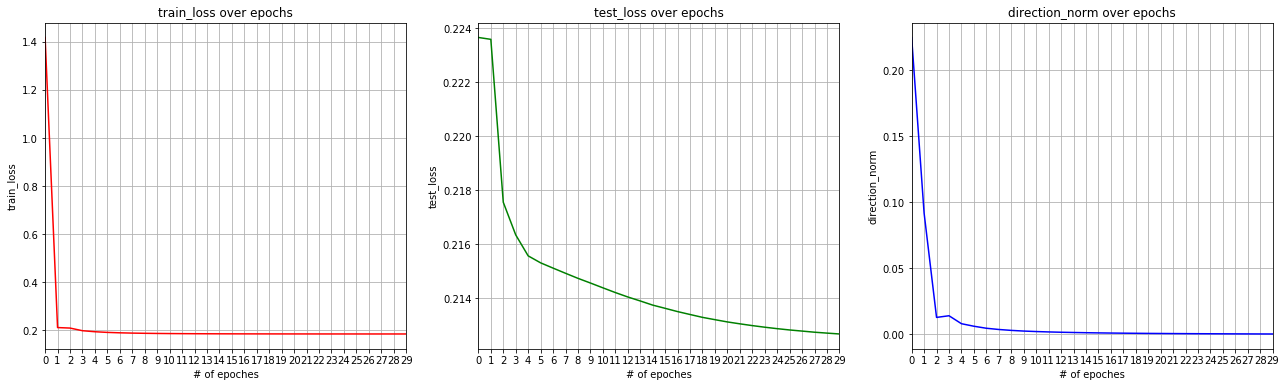

In [17]:
num_epochs = 30
lamda = 1 / (train_df_ijcnn1.shape[0] + test_df_ijcnn1.shape[0])
train_loss_saga, test_loss, d_norm_saga = SAGA(train_df_ijcnn1,test_df_ijcnn1,num_epochs,lamda,learning_rate=0.01)
print("SAGA算法——ijcnn1数据集结果:")
plot_statistic_curves(num_epochs,train_loss_saga,test_loss,d_norm_saga,name='ijcnn1_SAGA.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAGA算法的有效性以及鲁棒性

#### SVRG算法

Epoch Loop: 100%|██████████| 30/30 [01:49<00:00,  3.65s/it, direction_norm_epoch=0.000139, test_loss_epoch=0.213, train_loss_epoch=0.186]


SVRG算法——ijcnn1数据集结果:


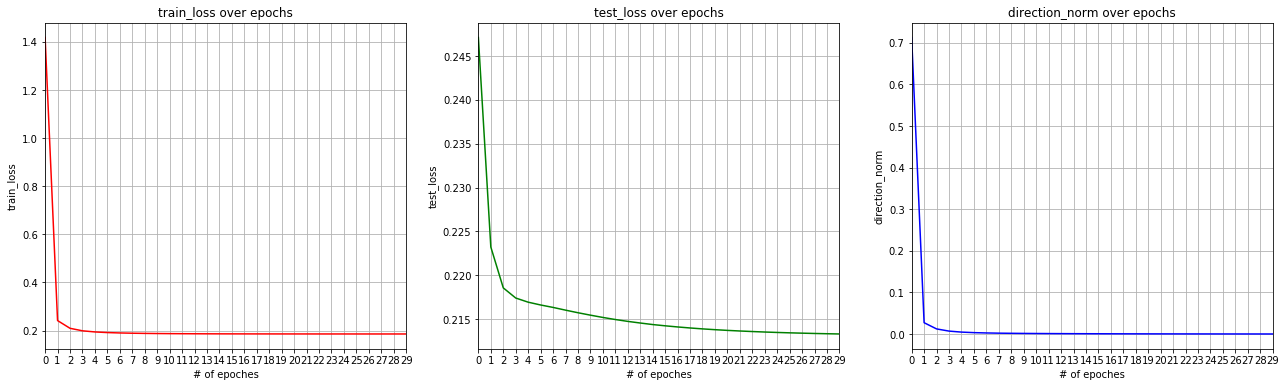

In [18]:
num_epochs = 30
lamda = 1e-5
train_loss_svrg, test_loss, d_norm_svrg = SVRG(train_df_ijcnn1,test_df_ijcnn1,num_epochs,lamda,learning_rate=0.01)
print("SVRG算法——ijcnn1数据集结果:")
plot_statistic_curves(num_epochs,train_loss_svrg,test_loss,d_norm_svrg,name='ijcnn1_SVRG.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SVRG算法的有效性以及鲁棒性

#### SARAH算法

Epoch Loop: 100%|██████████| 30/30 [01:51<00:00,  3.70s/it, direction_norm_epoch=9.71e-5, test_loss_epoch=0.213, train_loss_epoch=0.185] 


SARAH算法——ijcnn1数据集结果:


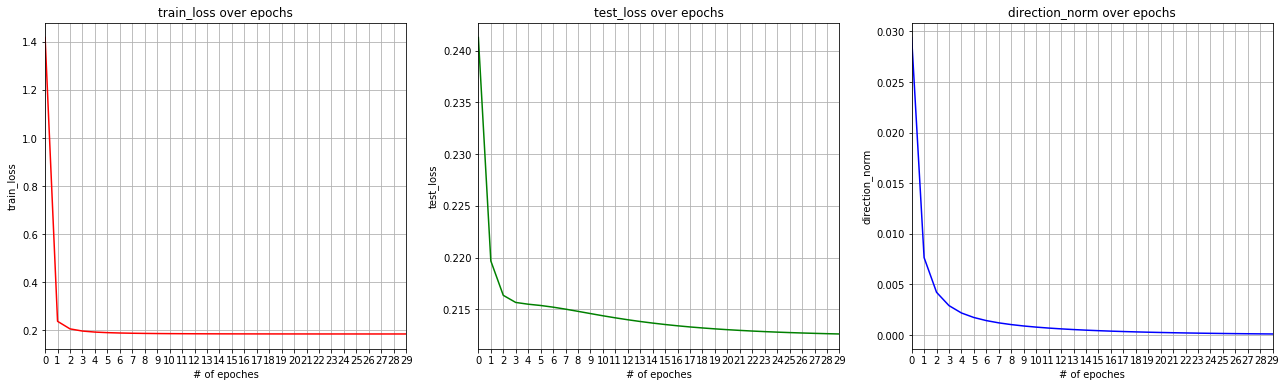

In [19]:
num_epochs = 30
lamda = 1 / (train_df_ijcnn1.shape[0] + test_df_ijcnn1.shape[0])
train_loss_sarah, test_loss, d_norm_sarah = SARAH(train_df_ijcnn1,test_df_ijcnn1,num_epochs,lamda,learning_rate=0.01)
print("SARAH算法——ijcnn1数据集结果:")
plot_statistic_curves(num_epochs,train_loss_sarah,test_loss,d_norm_sarah,name='ijcnn1_SARAH.png')

结果分析：可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SARAH算法的有效性以及鲁棒性

#### ijcnn1数据集上四类算法对比
**以下会按照要求，将四类算法的目标函数值与最优目标函数值之差变化曲线与迭代方向模长变化曲线放在一张图中对比！**  

Epoch Loop: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it, train_loss_epoch=0.185]


得到ijcnn1数据集optimum！！
然后画出ijcnn1在4个dataset上的对比图如下：


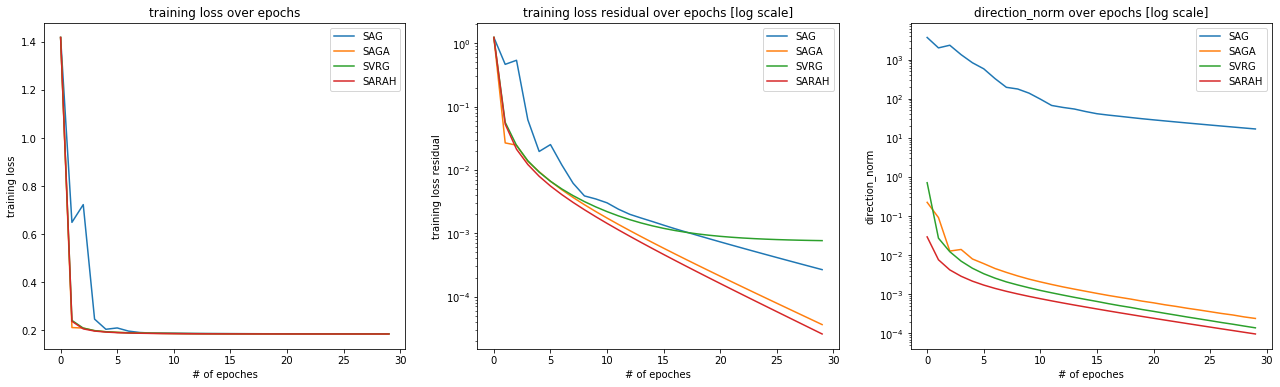

In [20]:
def optimum_ijcnn1(train_df,num_epoch,lamda,learning_rate):
    w = np.ones(train_df.shape[1]-2) # initialize w
    np.random.seed(0)
    train_loss = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            grad_global_i = 0
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
                grad_global_i += cal_grad_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            grad_global_i /= train_df.shape[0]
            w_last = w
            w_now = w - learning_rate * grad_global_i
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle；m=n
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                grad_global_i = cal_grad_i(xi,yi,w_now,lamda) - cal_grad_i(xi,yi,w_last,lamda) + grad_global_i
                w_last = w_now
                w_now = w_now - learning_rate * grad_global_i
            w = w_now # option I
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch)
    return np.min(train_loss)
optimum_ijcnn1 = optimum_ijcnn1(train_df_ijcnn1,50,1/(train_df_ijcnn1.shape[0]+test_df_ijcnn1.shape[0]),learning_rate=0.01)
print("得到ijcnn1数据集optimum！！\n然后画出ijcnn1在4个dataset上的对比图如下：")
########## 画图 ##########
fig = plt.figure(figsize=(22,6))
x_data = range(30)
plt.subplot(1,3,1)
plt.title('training loss over epochs')
plt.plot(x_data, train_loss_sag, label='SAG')
plt.plot(x_data, train_loss_saga, label='SAGA')
plt.plot(x_data, train_loss_svrg, label='SVRG')
plt.plot(x_data, train_loss_sarah, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('training loss')
plt.legend()
plt.subplot(1,3,2)
plt.title('training loss residual over epochs [log scale]')
plt.plot(x_data, train_loss_sag - optimum_ijcnn1, label='SAG')
plt.plot(x_data, train_loss_saga - optimum_ijcnn1, label='SAGA')
plt.plot(x_data, train_loss_svrg - optimum_ijcnn1, label='SVRG')
plt.plot(x_data, train_loss_sarah - optimum_ijcnn1, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('training loss residual')
plt.yscale("log")
plt.legend()
plt.subplot(1,3,3)
plt.title('direction_norm over epochs [log scale]')
plt.plot(x_data, d_norm_sag, label='SAG')
plt.plot(x_data, d_norm_saga, label='SAGA')
plt.plot(x_data, d_norm_svrg, label='SVRG')
plt.plot(x_data, d_norm_sarah, label='SARAH')
plt.xlabel('# of epoches')
plt.ylabel('direction_norm')
plt.yscale("log")
plt.legend()
fig.savefig('ijcnn1_4comparison.png',dpi=600,format='png',bbox_inches='tight')

#### 结果分析：
1、	首先可以看到四个算法在两个数据集上训练目标函数（loss函数）都快速下降并且收敛到差不多的数值。  
2、	**SAG算法的迭代方向模长比其他三个算法都高**：观察两个数据集迭代方向模长变化曲线不难发现SAG算法的曲线（蓝色）一枝独秀，比其他都大！这是为什么呢？原因很简单，**因为我这里SAG算法的迭代方向模长是取的全样本的梯度（没有除以总样本数n）**，因此跟其他三个算法是不可比的（其他三个算法都是样本平均梯度作为迭代方向），所以不必奇怪，**其实迭代方向本身也并非一个精确的概念（需要配合步长），因而将这里SAG的迭代方向模长除以样本数n也是可以的，那样的话就和其他三者差不多了**，这里我为了引出这个说明才专门按全梯度设计的。  
3、	**SAGA算法会比SAG算法有更快的线性收敛速度**：观察两个数据集的目标函数值与最优目标函数值之差的变化曲线，对比SAGA算法（黄线）之于SAG算法（蓝线），可以看到黄线一直在蓝线的下方，说明SAGA算法比SAG算法有更快的收敛速度，SAGA这样计算单个样本梯度的方式对参数更新的影响更大，证实SAGA的改进是有效的。  
4、	**SAGA算法会比SVRG算法有更快的线性收敛速度**：同样还是观察两个数据集的目标函数值与最优目标函数值之差的变化曲线，对比SAGA算法（黄线）之于SVRG算法（绿线），可以看到绿线在蓝线的下方，说明SAGA算法比SVRG算法有更快的收敛速度。  
5、	**SVRG算法在固定学习率下便可取得较快的收敛速度**：不难发现这里SVRG算法在两个数据集上收敛速度以及收敛结果表现都比较优异，其实除了算法本身还有一方面原因来自于我具体的实现细节，我实现时（详见源代码），四个算法都是用的固定学习率进行优化，因此其他三个算法可能由于固定学习率的关系外加我并没有刻意去调参（其实仔细考虑的话可能还有来自数据集的影响，w8a训练集样本类别分布极其不均衡，基本都是负类，极其少一部分是正类），故而没有达到真正意义上的最优，不过这也另一方面佐证了结论：SVRG算法在固定学习率下的确能取得较快的收敛速度。  
6、	**SARAH对于强凸的目标函数也是线性收敛的，只是收敛速度要慢于SVRG算法**：同样还是观察两个数据集的目标函数值与最优目标函数值之差的变化曲线，对比SARAH算法（红线）之于SVRG算法（绿线），ijcnn1数据集的结果中可以看到SARAH效果优于SVRG，说明优化还是有一定的效果，同时从w8a数据集的结果可以看到SARAH收敛速度略慢于SVRG。